# Introduction to Deep Learning, Assignment 2, Task 2

# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*

When using the Lab Computers, download the Jupyter Notebook to one of the machines first.

If you want to use Google Colab, you should first copy this notebook and enable GPU runtime in 'Runtime -> Change runtime type -> Hardware acceleration -> GPU **OR** TPU'.


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [ ]:
# Source - https://stackoverflow.com/a
# Posted by HamzaMushtaq
# Retrieved 2025-11-18, License - CC BY-SA 4.0

#!pip3 install opencv-python
#!pip install opencv-python==4.8.1.78 numpy==1.26.4

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 14.9 MB/s eta 0:00:00m eta 0:00:010:01:01
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.12.0.88
    Uninstalling opencv-python-4.12.0.88:
      Successfully uninstalled opencv-python-4.12.0.88


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

2025-11-20 15:34:55.619664: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-20 15:34:55.620037: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-20 15:34:55.621941: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-20 15:34:55.627280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-20 15:34:55.635797: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

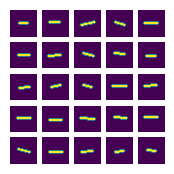

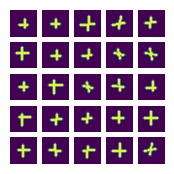

In [3]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [4]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #5188

X_text: "25+94" = y_text: "119"


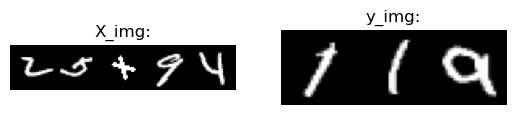

Query #5711

X_text: "28-55" = y_text: "-27"


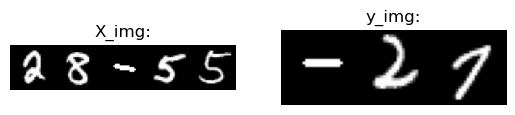

Query #4930

X_text: "24+65" = y_text: "89 "


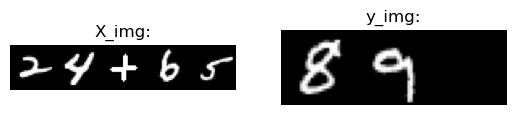

Query #1969

X_text: "9-84 " = y_text: "-75"


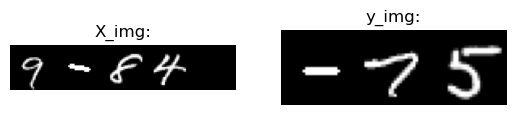

Query #2102

X_text: "10+51" = y_text: "61 "


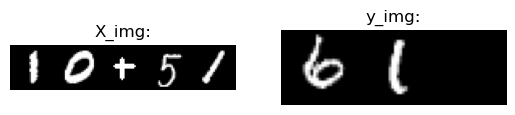

Query #7210

X_text: "36+5 " = y_text: "41 "


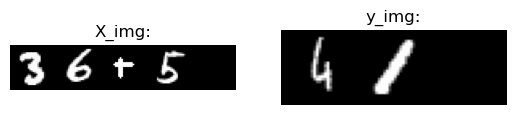

Query #2481

X_text: "12-40" = y_text: "-28"


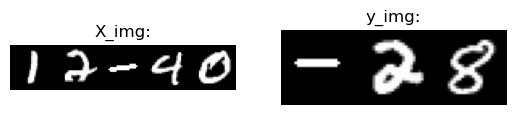

Query #6355

X_text: "31-77" = y_text: "-46"


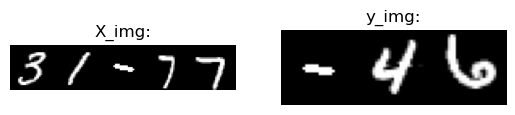

Query #5042

X_text: "25+21" = y_text: "46 "


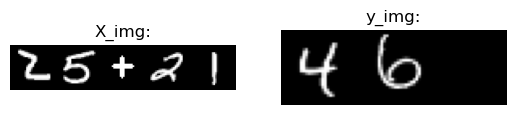

Query #3106

X_text: "15+53" = y_text: "68 "


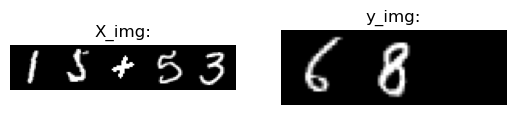

In [5]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

## Helper functions

The functions below will help with input/output of the data.

In [6]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=2)
    predicted = [''.join([unique_characters[i] for i in j]) for j in pred]

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [7]:
def build_text2text_model():

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

In [8]:
## Your code (look at the assignment description for your tasks for text-to-text model):
#(## Your first task is to fit the text2text model using X_text and y_text)
# Build the model
text2text_model = build_text2text_model()

# Train the model with 50% train / 50% test split
X_train, X_test, y_train, y_test = train_test_split(
    X_text_onehot, y_text_onehot, test_size=0.5, random_state=42
)

history = text2text_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate model
train_loss, train_acc = text2text_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = text2text_model.evaluate(X_test, y_test, verbose=0)

print(f"\n{'='*50}")
print(f"50% Train / 50% Test Split Results:")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"{'='*50}\n")





I0000 00:00:1763649309.882896 2712639 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-20 15:35:09.886455: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/vol/home/s4251938/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3608 - loss: 1.9274 - val_accuracy: 0.3982 - val_loss: 1.6941
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4353 - loss: 1.5778 - val_accuracy: 0.4763 - val_loss: 1.4367
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4956 - loss: 1.3856 - val_accuracy: 0.5420 - val_loss: 1.2963
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5311 - loss: 1.2894 - val_accuracy: 0.5347 - val_loss: 1.2655
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5635 - loss: 1.2092 - val_accuracy: 0.5730 - val_loss: 1.1558
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5763 - loss: 1.1567 - val_accuracy: 0.5668 - val_loss: 1.1633
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5876 - loss: 1.1292 - val_accuracy: 0.6115 - val_loss: 1.0741
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6059 - loss: 1.0672 - val_accuracy: 0.

In [9]:
#multiple splits 
split_ratios = [0.5, 0.25, 0.1]  # test_size values (50%, 75%, 90%)
results = {}

for test_size in split_ratios:
    train_size = 1 - test_size

    X_train, X_test, y_train, y_test, X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(
        X_text_onehot, y_text_onehot, X_text, y_text,
        test_size=test_size, random_state=42
    )

    # Build model for each split
    model = build_text2text_model()

    # Train model
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

    # Evaluate
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    results[f"{int(train_size*100)}-{int(test_size*100)}"] = {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'model': model,
        'X_test': X_test,
        'y_test': y_test,
        'X_text_test': X_text_test,
        'y_text_test': y_text_test
    }

    print(f"\n{int(train_size*100)}% Train / {int(test_size*100)}% Test:")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy:  {test_acc:.4f}")



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)


50% Train / 50% Test:
  Train Accuracy: 0.9913
  Test Accuracy:  0.9825


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)


75% Train / 25% Test:
  Train Accuracy: 0.9969
  Test Accuracy:  0.9925


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)


90% Train / 10% Test:
  Train Accuracy: 0.9989
  Test Accuracy:  0.9960


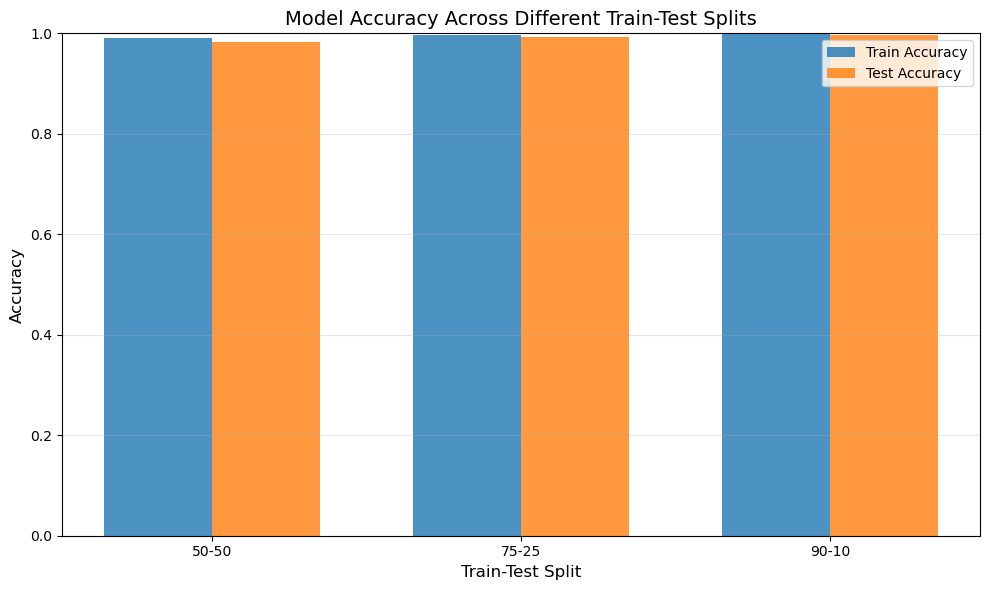

In [10]:
# Plot accuracy comparison
split_labels = list(results.keys())
train_accs = [results[split]['train_acc'] for split in split_labels]
test_accs = [results[split]['test_acc'] for split in split_labels]

plt.figure(figsize=(10, 6))
x = np.arange(len(split_labels))
width = 0.35

plt.bar(x - width/2, train_accs, width, label='Train Accuracy', alpha=0.8)
plt.bar(x + width/2, test_accs, width, label='Test Accuracy', alpha=0.8)

plt.xlabel('Train-Test Split', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Accuracy Across Different Train-Test Splits', fontsize=14)
plt.xticks(x, split_labels)
plt.legend()
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
# Function to find and visualize misclassifications
def analyze_mistakes(model, X_test, y_test, X_text_test, y_text_test, n_mistakes=10):

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_decoded = decode_labels(y_pred)
    y_test_decoded = decode_labels(y_test)

    # Find where predictions don not match
    mistakes_idx = []
    for i in range(len(y_pred_decoded)):
        if y_pred_decoded[i] != y_test_decoded[i]:
            mistakes_idx.append(i)

    print(f"\nTotal Mistakes: {len(mistakes_idx)} / {len(y_pred_decoded)}")
    print(f"Accuracy: {(len(y_pred_decoded) - len(mistakes_idx)) / len(y_pred_decoded):.4f}\n")

    # Display first n mistakes
    n_show = min(n_mistakes, len(mistakes_idx))

    plt.figure(figsize=(15, 3*n_show))
    for idx_num, mistake_idx in enumerate(mistakes_idx[:n_show]):
        plt.subplot(n_show, 1, idx_num + 1)
        plt.axis('off')

        query = X_text_test[mistake_idx]
        expected = y_text_test[mistake_idx]   
        predicted = y_pred_decoded[mistake_idx]

        plt.text(0.05, 0.7, f"Query:     '{query}'", fontsize=14, family='monospace', transform=plt.gca().transAxes)
        plt.text(0.05, 0.4, f"Expected:  '{expected}'", fontsize=14, family='monospace', color='green', transform=plt.gca().transAxes)
        plt.text(0.05, 0.1, f"Predicted: '{predicted}'", fontsize=14, family='monospace', color='red', transform=plt.gca().transAxes)
        plt.text(0.6, 0.5, f"WRONG", fontsize=16, color='red', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

    return mistakes_idx

In [12]:
def categorize_mistakes(model, X_test, y_test, X_text_test, y_text_test):

    y_pred = model.predict(X_test, verbose=0)
    y_pred_decoded = decode_labels(y_pred)
    y_test_decoded = decode_labels(y_test)

    mistake_types = {
        'off_by_one': 0,
        'sign_wrong': 0,
        'magnitude_wrong': 0,
        'completely_wrong': 0
    }

    examples = {k: [] for k in mistake_types.keys()}

    for i in range(len(y_pred_decoded)):
        if y_pred_decoded[i] != y_test_decoded[i]:
            pred_val = y_pred_decoded[i].strip()
            true_val = y_test_decoded[i].strip()
            query = X_text_test[i].strip()

            try:
                pred_num = int(pred_val) if pred_val else 0
                true_num = int(true_val) if true_val else 0

                if abs(pred_num - true_num) == 1:
                    mistake_types['off_by_one'] += 1
                    examples['off_by_one'].append((query, true_val, pred_val))
                elif (pred_num > 0) != (true_num > 0): 
                    mistake_types['sign_wrong'] += 1
                    examples['sign_wrong'].append((query, true_val, pred_val))
                elif pred_num != true_num:
                    mistake_types['magnitude_wrong'] += 1
                    examples['magnitude_wrong'].append((query, true_val, pred_val))
            except:
                mistake_types['completely_wrong'] += 1
                examples['completely_wrong'].append((query, true_val, pred_val))

    # Print statistics
    print("MISTAKE ANALYSIS")
    for mistake_type, count in mistake_types.items():
        percentage = (count / len(y_test)) * 100 if len(y_test) > 0 else 0
        print(f"\n{mistake_type.upper()}: {count} ({percentage:.2f}%)")

        # Show first 3 examples
        for j, (query, expected, predicted) in enumerate(examples[mistake_type][:3]):
            print(f"  Example {j+1}: '{query}' --- Expected: '{expected}', Got: '{predicted}'")

    return mistake_types, examples


MISTAKE ANALYSIS FOR EACH SPLIT
SPLIT: 50% Train / 50% Test

Visual Examples of Mistakes:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Total Mistakes: 498 / 10000
Accuracy: 0.9502



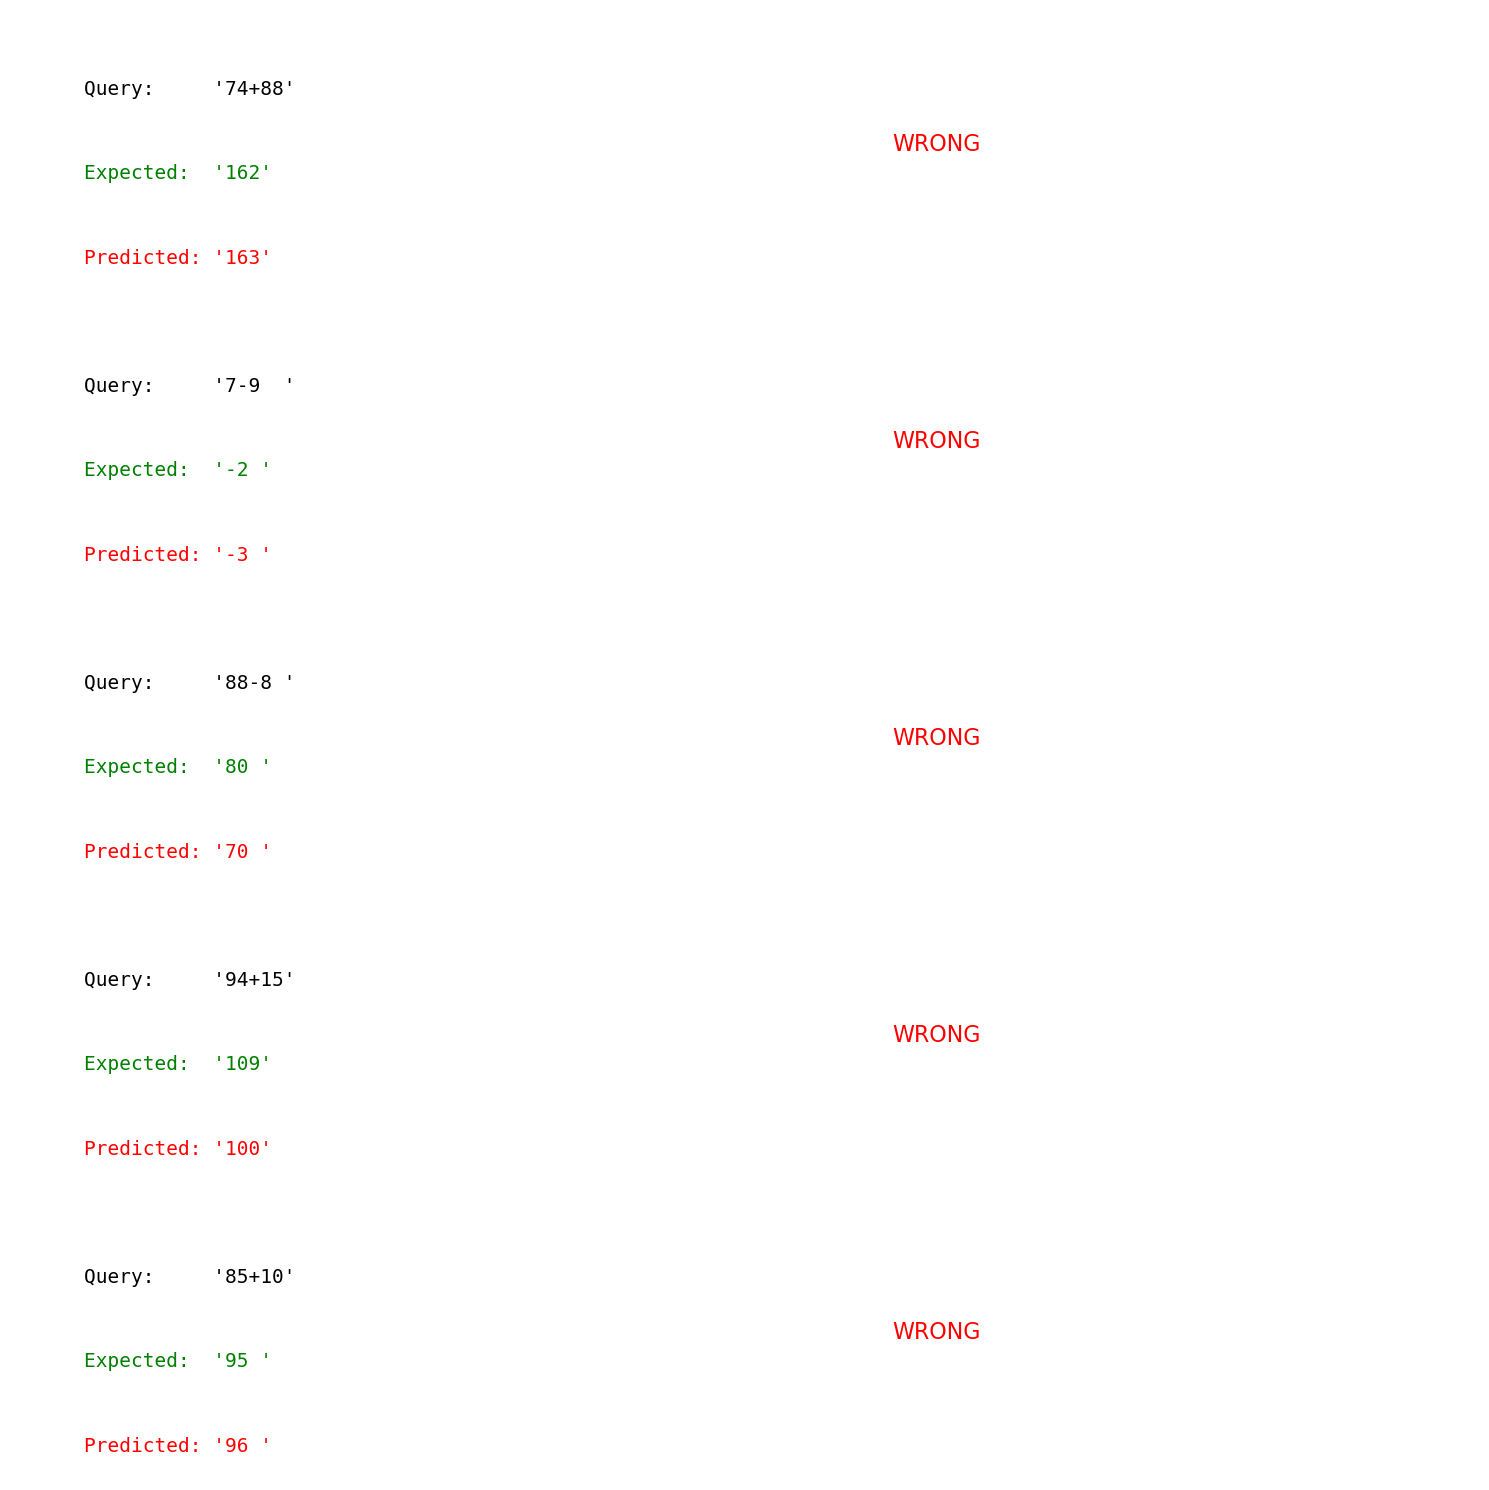

MISTAKE ANALYSIS

OFF_BY_ONE: 220 (2.20%)
  Example 1: '74+88' --- Expected: '162', Got: '163'
  Example 2: '7-9' --- Expected: '-2', Got: '-3'
  Example 3: '85+10' --- Expected: '95', Got: '96'

SIGN_WRONG: 1 (0.01%)
  Example 1: '21-22' --- Expected: '-1', Got: '01'

MAGNITUDE_WRONG: 271 (2.71%)
  Example 1: '88-8' --- Expected: '80', Got: '70'
  Example 2: '94+15' --- Expected: '109', Got: '100'
  Example 3: '31+8' --- Expected: '39', Got: '49'

COMPLETELY_WRONG: 6 (0.06%)
  Example 1: '0-9' --- Expected: '-9', Got: '-'
  Example 2: '7-6' --- Expected: '1', Got: '-'
  Example 3: '5-5' --- Expected: '0', Got: '-'
SPLIT: 75% Train / 25% Test

Visual Examples of Mistakes:
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Total Mistakes: 112 / 5000
Accuracy: 0.9776



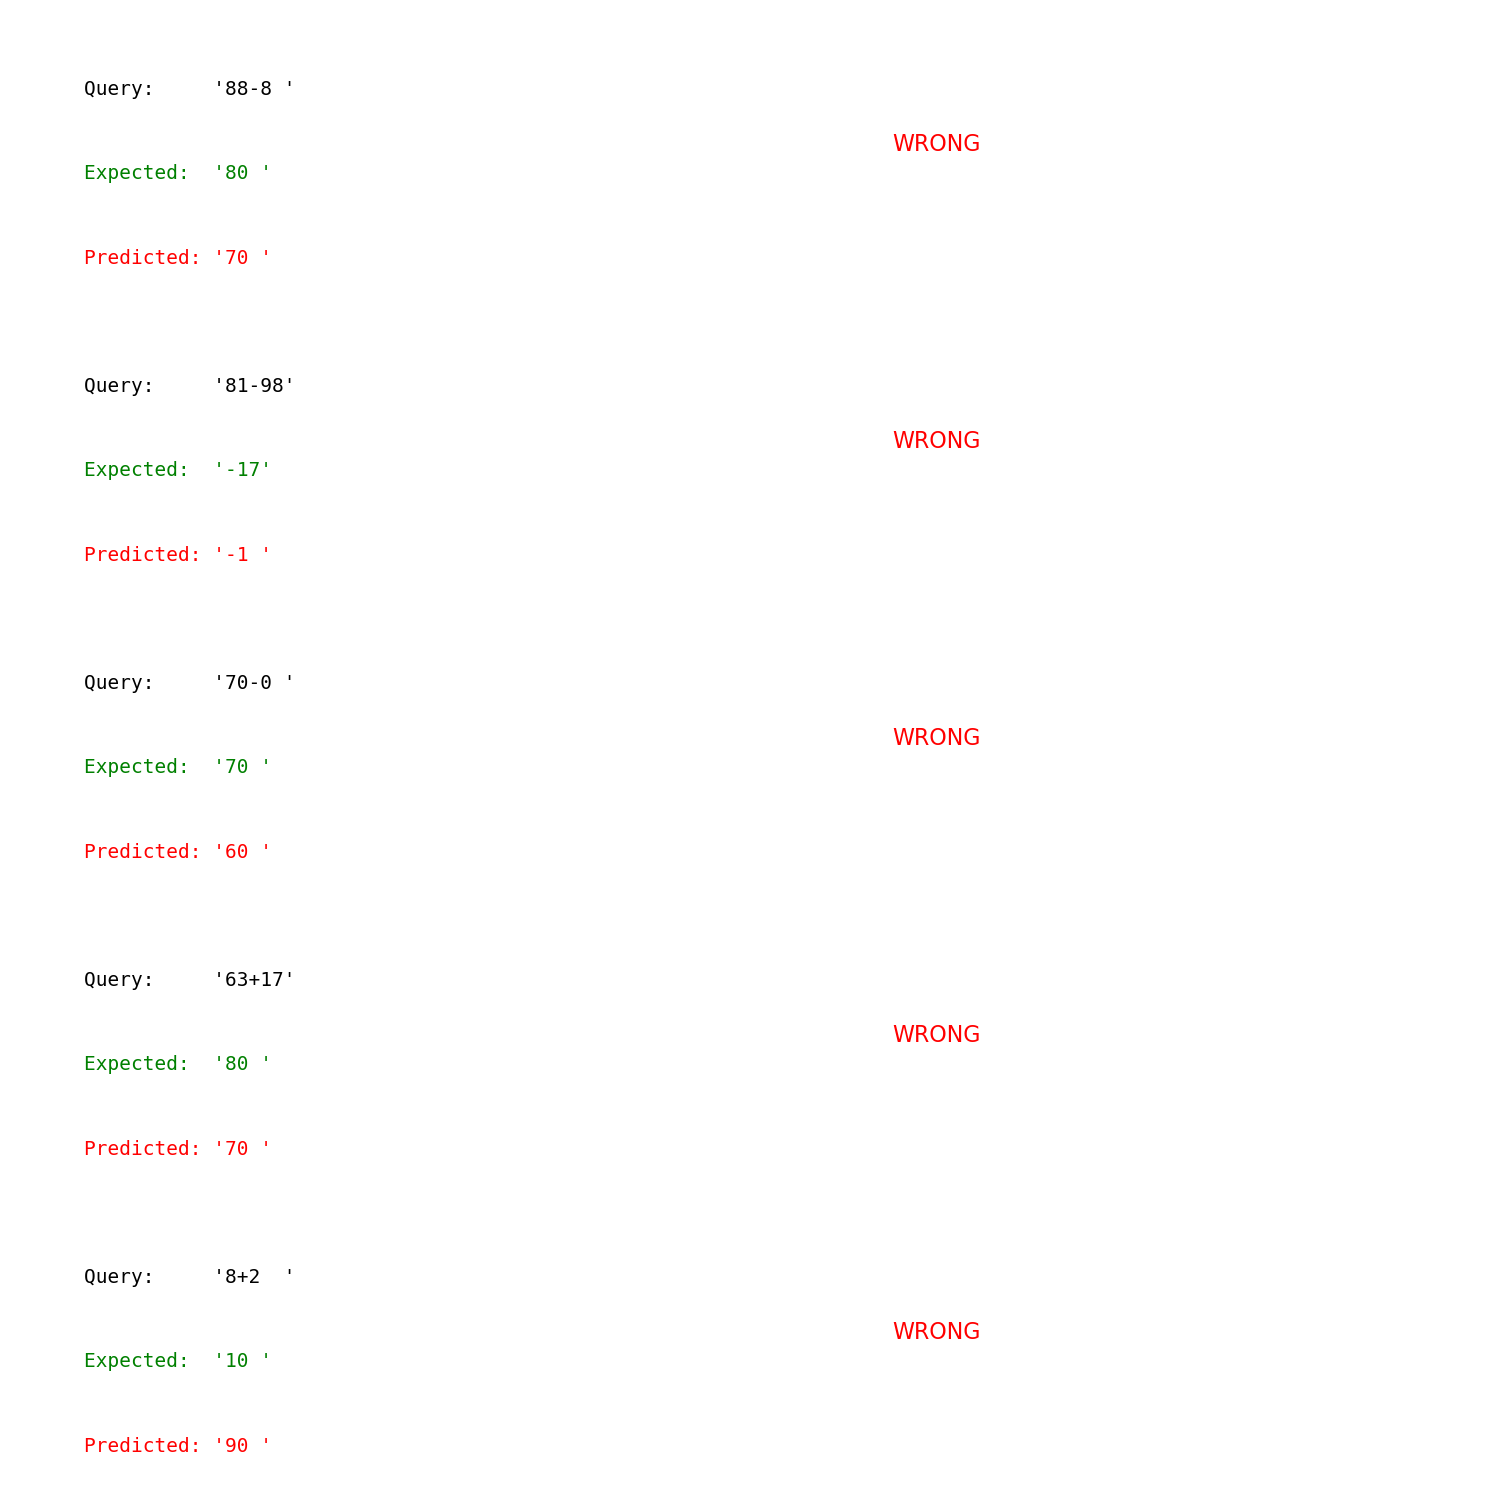

MISTAKE ANALYSIS

OFF_BY_ONE: 44 (0.88%)
  Example 1: '3+3' --- Expected: '6', Got: '5'
  Example 2: '4-1' --- Expected: '3', Got: '4'
  Example 3: '91-5' --- Expected: '86', Got: '85'

SIGN_WRONG: 1 (0.02%)
  Example 1: '0+0' --- Expected: '0', Got: '2'

MAGNITUDE_WRONG: 66 (1.32%)
  Example 1: '88-8' --- Expected: '80', Got: '70'
  Example 2: '81-98' --- Expected: '-17', Got: '-1'
  Example 3: '70-0' --- Expected: '70', Got: '60'

COMPLETELY_WRONG: 1 (0.02%)
  Example 1: '0-1' --- Expected: '-1', Got: '-'
SPLIT: 90% Train / 10% Test

Visual Examples of Mistakes:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Total Mistakes: 19 / 2000
Accuracy: 0.9905



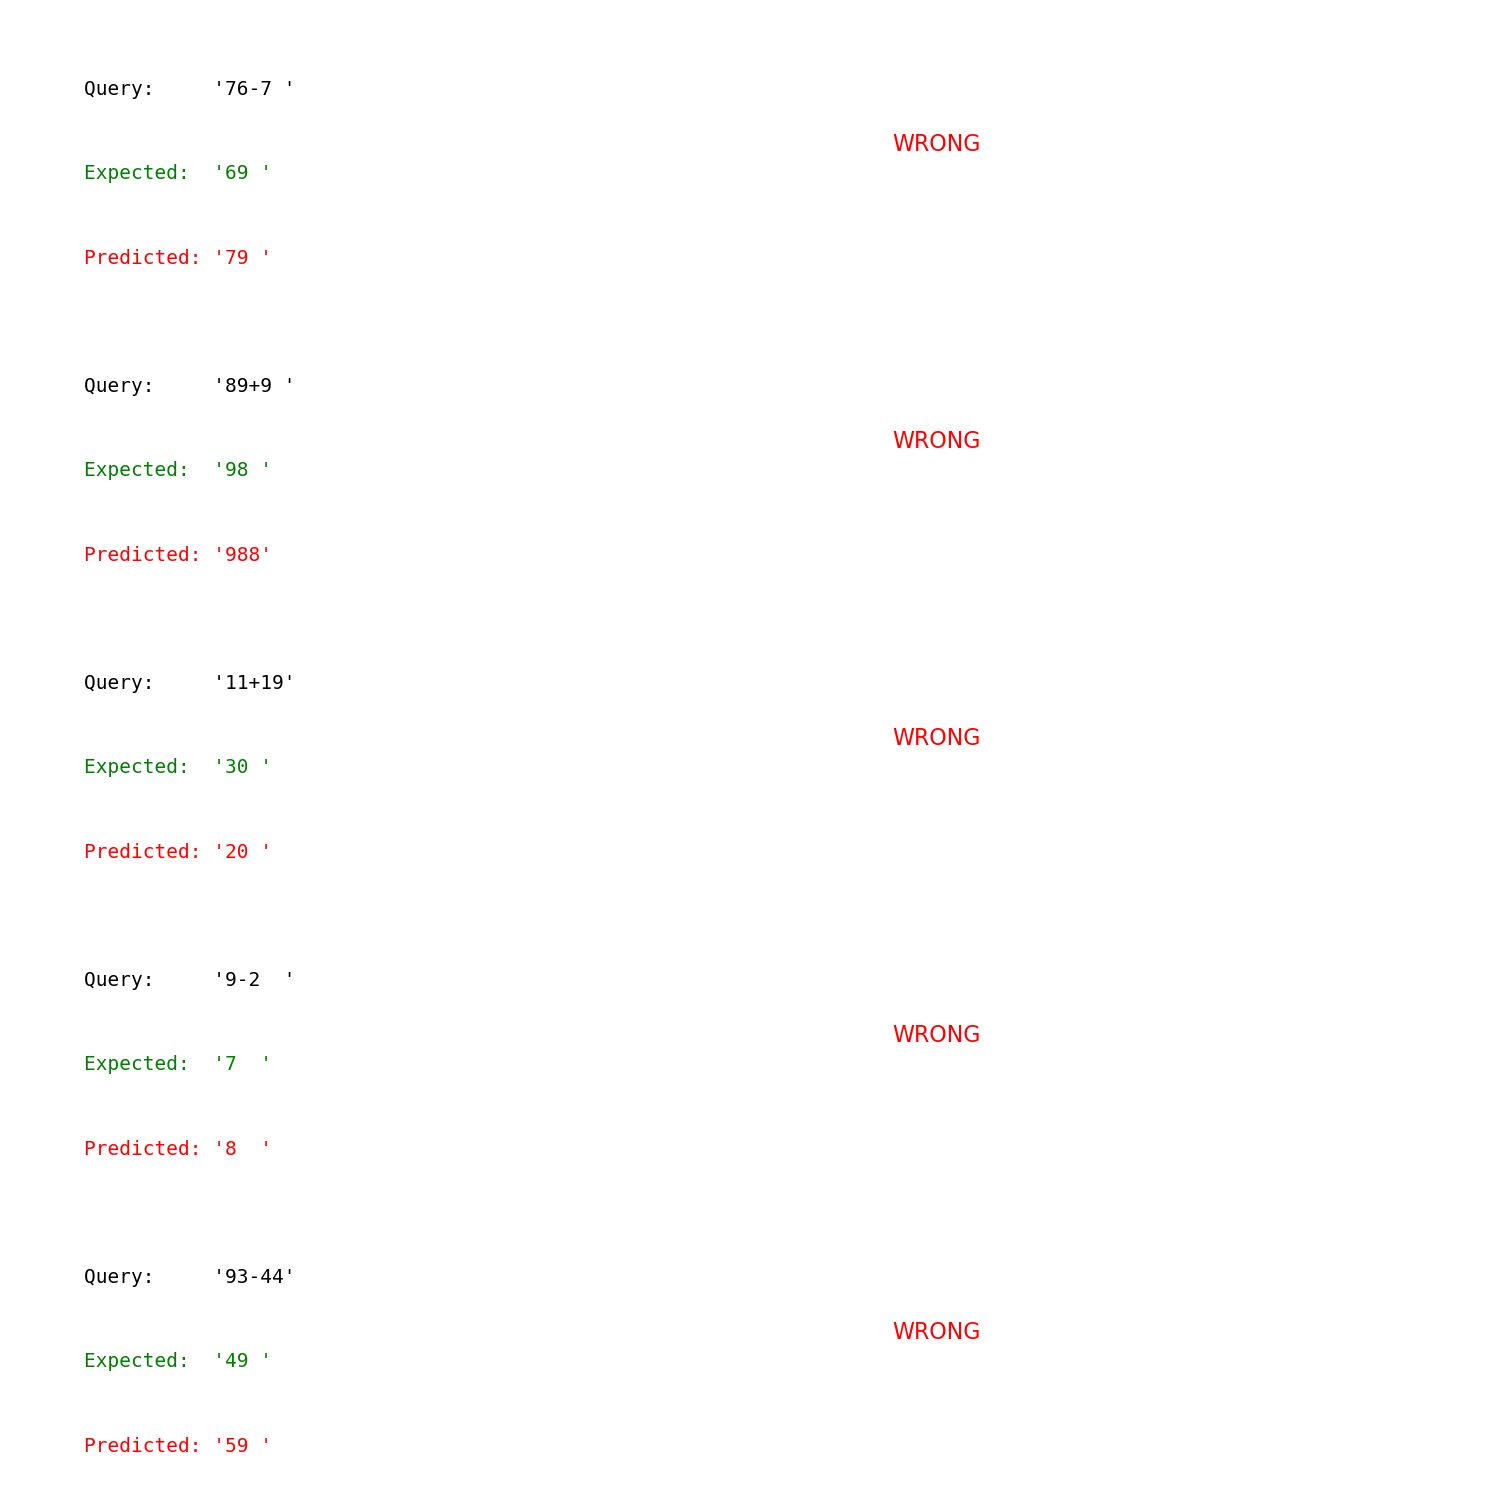

MISTAKE ANALYSIS

OFF_BY_ONE: 8 (0.40%)
  Example 1: '9-2' --- Expected: '7', Got: '8'
  Example 2: '15-5' --- Expected: '10', Got: '9'
  Example 3: '17-7' --- Expected: '10', Got: '9'

SIGN_WRONG: 0 (0.00%)

MAGNITUDE_WRONG: 11 (0.55%)
  Example 1: '76-7' --- Expected: '69', Got: '79'
  Example 2: '89+9' --- Expected: '98', Got: '988'
  Example 3: '11+19' --- Expected: '30', Got: '20'

COMPLETELY_WRONG: 0 (0.00%)


In [13]:
# Analyze mistakes for each split
print("MISTAKE ANALYSIS FOR EACH SPLIT")

for split_name in sorted(results.keys(), key=lambda x: int(x.split('-')[1]), reverse=True):
    split_data = results[split_name]
    train_size, test_size = map(int, split_name.split('-'))

    print(f"SPLIT: {train_size}% Train / {test_size}% Test")

    # Show visual examples of mistakes
    print(f"\nVisual Examples of Mistakes:")
    mistakes_idx = analyze_mistakes(
        split_data['model'],
        split_data['X_test'],
        split_data['y_test'],
        split_data['X_text_test'],
        split_data['y_text_test'],
        n_mistakes=5  
    )

    # Categorize and analyze mistake types
    mistake_types, examples = categorize_mistakes(
        split_data['model'],
        split_data['X_test'],
        split_data['y_test'],
        split_data['X_text_test'],
        split_data['y_text_test']
    )

COMPARISON ACROSS ALL SPLITS

Split           Train Acc    Test Acc     Gen Gap      Mistakes       
----------------------------------------------------------------------
90-10           0.9989       0.9960       0.0029       19/2000
75-25           0.9969       0.9925       0.0045       112/5000
50-50           0.9913       0.9825       0.0088       498/10000


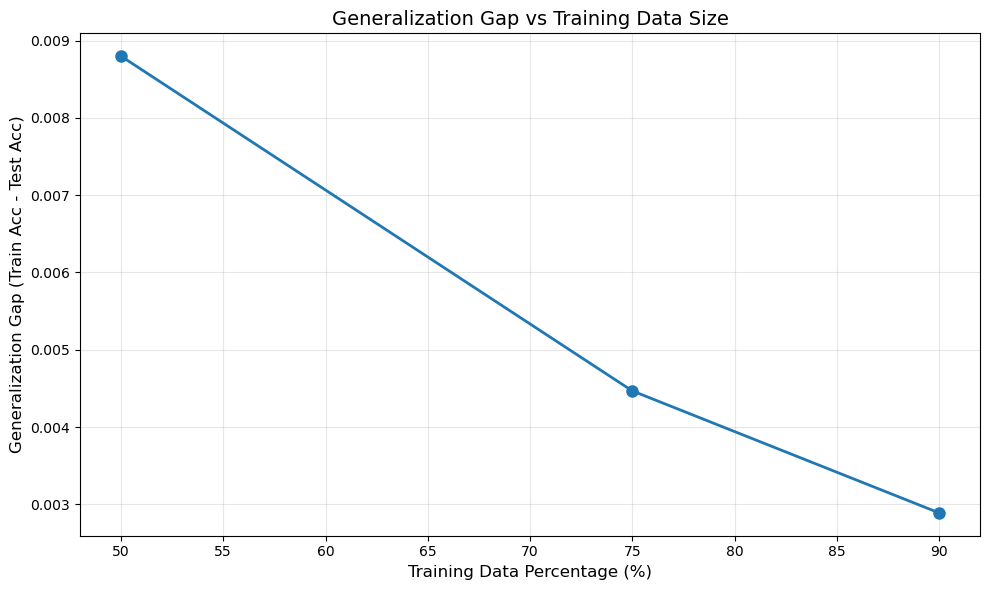

In [14]:
print("COMPARISON ACROSS ALL SPLITS")

summary_data = []
for split_name in sorted(results.keys(), key=lambda x: int(x.split('-')[0]), reverse=True):
    split_data = results[split_name]
    train_size, test_size = map(int, split_name.split('-'))

    # Calculate number of mistakes
    y_pred = split_data['model'].predict(split_data['X_test'], verbose=0)
    y_pred_decoded = decode_labels(y_pred)
    y_test_decoded = decode_labels(split_data['y_test'])

    num_mistakes = sum([1 for i in range(len(y_pred_decoded)) if y_pred_decoded[i] != y_test_decoded[i]])

    summary_data.append({
        'split': split_name,
        'train_size': train_size,
        'test_size': test_size,
        'train_acc': split_data['train_acc'],
        'test_acc': split_data['test_acc'],
        'gen_gap': split_data['train_acc'] - split_data['test_acc'],
        'num_mistakes': num_mistakes,
        'total_samples': len(y_test_decoded)
    })

# Display table
print(f"\n{'Split':<15} {'Train Acc':<12} {'Test Acc':<12} {'Gen Gap':<12} {'Mistakes':<15}")
print("-" * 70)
for data in summary_data:
    print(f"{data['split']:<15} {data['train_acc']:<12.4f} {data['test_acc']:<12.4f} "
          f"{data['gen_gap']:<12.4f} {data['num_mistakes']}/{data['total_samples']}")

# Plot generalization gap
plt.figure(figsize=(10, 6))
train_sizes = [d['train_size'] for d in summary_data]
gen_gaps = [d['gen_gap'] for d in summary_data]

plt.plot(train_sizes, gen_gaps, marker='o', linewidth=2, markersize=8)
plt.xlabel('Training Data Percentage (%)', fontsize=12)
plt.ylabel('Generalization Gap (Train Acc - Test Acc)', fontsize=12)
plt.title('Generalization Gap vs Training Data Size', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as input vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [15]:
## Your code





---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [16]:
# Your code




